# Introdution:

## Reimplimentation of YOLO v1 

**I have tried to  expalin and reimplemnet the YOLO 2017 paper.**

**Training Dataset = Pasxal Voc 2012**
**Testing Data = COCO 2017**

**Original paper:** [https://arxiv.org/abs/1506.02640](https://arxiv.org/abs/1506.02640)

**My Linked in Profile:** [https://www.linkedin.com/in/saurabh-maulekhi-326584241/](https://www.linkedin.com/in/saurabh-maulekhi-326584241/)

**My Github Repo:** [https://github.com/Saurabh-Maulekhi/YOLO-V1-2017](https://github.com/Saurabh-Maulekhi/YOLO-V1-2017)

# Importing Libraries

In [1]:
import tensorflow as tf### models
import numpy as np### math computations
import seaborn as sns### visualizations
import matplotlib.pyplot as plt### plotting bar chart
import matplotlib.image as img 
import datetime
import pathlib
import io
from datetime import datetime
import json
import xml.etree.ElementTree as ET
import os
import shutil
import cv2
import time
import random
from PIL import Image
import albumentations as A
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape, LeakyReLU)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)
from tensorflow.keras.regularizers import L2, L1
from tensorflow.keras.initializers import RandomNormal

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.24 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# Dataset Preparation

## **Variables and Constants Definations and Explnations**

* **B**: Number of bounding boxes to be predicted by our model conatining object (Only box with highestr score will be shown)


* **N_CLASSES**: Number of Classes on which model will train.

* **H, W**: Height and width of image that we will  convert into.

* **SPLIT_SIZE / S**: Size in which we will split our image from both horizontally and vertically and create cellls.

* **N_EPOCHS**: Number of epochs/iterationsto train our model. Beacuse kaggle only give 12 hours so we are only using 60 epochs, unlike original paper that used 135 Epochs.

* **BATCH_SIZE**:  number of samples (images) loaded at a time to train a model with. So you'd load 32 images at a time and feed them to your model.

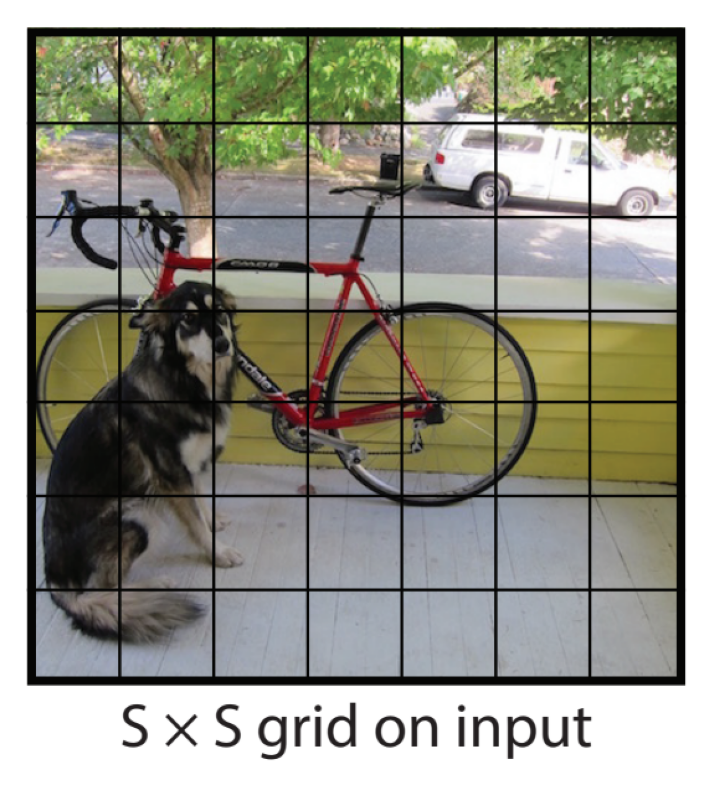

In [2]:
## Image examplde
image = img.imread("/kaggle/input/yolo-concepts-explanation/varibales.png")
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(image);

In [3]:
train_images =  "/kaggle/input/pascal-voc-2012/VOC2012/JPEGImages/"
train_maps = "/kaggle/input/pascal-voc-2012/VOC2012/Annotations/"

val_images = "/kaggle/working/VOC2012/ValJPEGImages/"
val_maps = "/kaggle/working/VOC2012/ValAnnotations/"

classes=['aeroplane','bicycle','bird','boat','bottle','bus','car','cat','chair','cow','diningtable',
         'dog','horse','motorbike','person','pottedplant','sheep','sofa','train','tvmonitor']


##### important variables and constants
B = 2
N_CLASSES = len(classes)
H, W = 244, 244  ## in original paper 224x224 were used to train image classifier and 448x448 for object detection
                 ## but we are using 224X224 for both
SPLIT_SIZE = H//32
print("SPLIT_SIZE : ", SPLIT_SIZE)
N_EPOCHS =   60   ##135
BATCH_SIZE = 32

SPLIT_SIZE :  7


In [4]:
### Creating Directories to put our validation images and their annotations to separate training and validation dataset

os.makedirs( "/kaggle/working/VOC2012/ValJPEGImages/")

os.makedirs("/kaggle/working/VOC2012/ValAnnotations/")

In [5]:
### validation images list
val_list=['2007_000027.jpg','2007_000032.jpg','2007_000033.jpg','2007_000039.jpg','2007_000042.jpg','2007_000061.jpg',
          '2007_000063.jpg','2007_000068.jpg','2007_000121.jpg','2007_000123.jpg','2007_000129.jpg','2007_000170.jpg',
          '2007_000175.jpg','2007_000187.jpg','2007_000241.jpg','2007_000243.jpg','2007_000250.jpg','2007_000256.jpg',
          '2007_000272.jpg','2007_000323.jpg','2007_000332.jpg','2007_000333.jpg','2007_000346.jpg','2007_000363.jpg',
          '2007_000364.jpg','2007_000392.jpg','2007_000423.jpg','2007_000452.jpg','2007_000464.jpg','2007_000480.jpg',
          '2007_000491.jpg','2007_000504.jpg','2007_000515.jpg','2007_000528.jpg','2007_000529.jpg','2007_000549.jpg',
          '2007_000559.jpg','2007_000572.jpg','2007_000584.jpg','2007_000629.jpg','2007_000636.jpg','2007_000645.jpg',
          '2007_000648.jpg','2007_000661.jpg','2007_000663.jpg','2007_000664.jpg','2007_000676.jpg','2007_000713.jpg',
          '2007_000720.jpg','2007_000727.jpg','2007_000733.jpg','2007_000738.jpg','2007_000762.jpg','2007_000768.jpg',
          '2007_000783.jpg','2007_000793.jpg','2007_000799.jpg','2007_000804.jpg','2007_000807.jpg','2007_000822.jpg',
          '2007_001299.jpg','2007_001311.jpg','2007_001321.jpg','2007_001340.jpg']


### validation images annotations list
val_list_maps=[i[:-3]+"xml" for i in val_list ]

In [6]:
## copying valdidation images and their annotations to validation directories
for name in val_list_maps:
    shutil.copy(train_maps + name, val_maps+name)

for name in val_list:
    shutil.copy(train_images+name, val_images+name)

In [7]:
##### checking number of images and annotations in directories

print("number of validation images in new directory: ", len(os.listdir(val_maps))," , ", "number of validation annotations in new directory: ",len(os.listdir(val_images)))

print("number of images in original directory: ", len(os.listdir(train_maps))," , ", "number of annotations in original directory: " , len(os.listdir(train_images)))

number of validation images in new directory:  64  ,  number of validation annotations in new directory:  64
number of images in original directory:  17125  ,  number of annotations in original directory:  17125


**Bounding_box** : It is a Box that contains objects.

*YOLO Format which we will use for training*: [xmin , ymin, xmax , ymax, Classe]

*YOLO Format which we will use for training*: [xcenter , ycenter, height , width, Classe] 



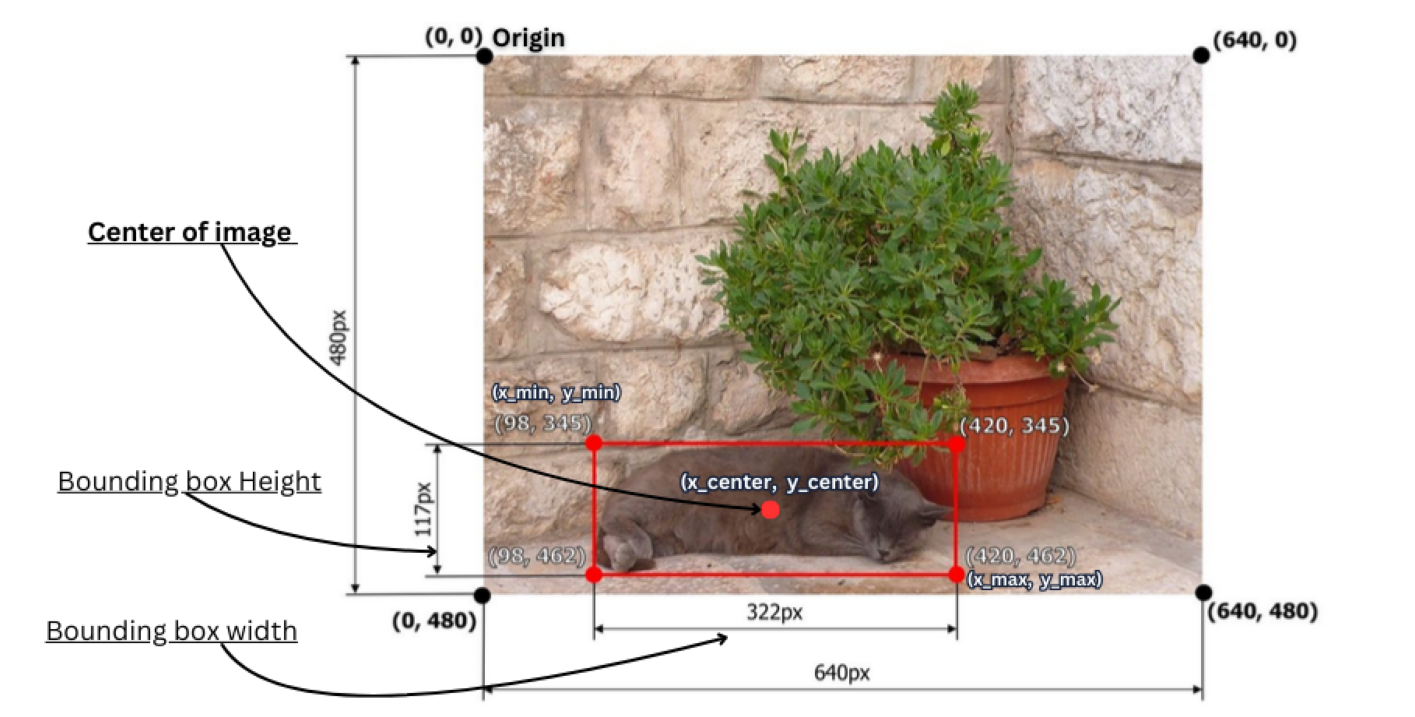

In [8]:
## Explaning co-ordinate system
image = img.imread("/kaggle/input/yolo-concepts-explanation/co-ordinate system.png" )
plt.figure(figsize=(18, 50))
plt.axis('off')
plt.imshow(image);

In [9]:
###### function to read annotation 

def preprocess_xml(filename):
    tree = ET.parse(filename)           ## Creating the element tree object by using xml file
    root = tree.getroot()               ## Getting root element from Element Tree
    size_tree = root.find('size')       ## Getiing size element in the root  Element
    height = float(size_tree.find('height').text)  ## Getting image height element's value and covert it into float
    width = float(size_tree.find('width').text)    ## Getting image width element's value and covert it into float
    bounding_boxes = []
    
    for object_tree in root.findall('object'):  ## Iterating over all the elements in object node
        for bounding_box in object_tree.iter('bndbox'):  ## Iterating over all elements in bndbox 
            xmin = (float(bounding_box.find('xmin').text))  ## xmin coordinate for object
            ymin = (float(bounding_box.find('ymin').text))  ## ymin coordinate for object
            xmax = (float(bounding_box.find('xmax').text))  ## xmax coordinate for object
            ymax = (float(bounding_box.find('ymax').text))  ## ymax coordinate for object
            break
        class_name = object_tree.find('name').text      ## class of object in strings
        
        ##### creating dictionary for objects in {key(int): value(strings)} format by using indexes of classes List 
        class_dict = {classes[i]: i for i in range(len(classes))}  
        
        bounding_box = [     ## bounding box 

            ### fiinding and normalising Values (by images width and height ): 
            ###  xcentre                 ### ycenter               ###box_width       ###box_height     ### gettinng class value from class dictionary
#                    |                          |                       |                   |                    |
#                    V                          V                       V                   V                    V
              (xmin+xmax)/(2*width), (ymin+ymax)/(2*height), (xmax-xmin)/width,  (ymax-ymin)/height, class_dict[class_name]]
        
        bounding_boxes.append(bounding_box)
        
    return tf.convert_to_tensor(bounding_boxes)  ## returning tensor of bounding boxes in an annotation for an image

In [10]:
## Taking an example  of a an image that has multiple objects 
preprocess_xml(val_maps+"2007_000032.xml")

<tf.Tensor: shape=(4, 5), dtype=float32, numpy=
array([[ 0.479     ,  0.4644128 ,  0.542     ,  0.37366548,  0.        ],
       [ 0.33      ,  0.37544483,  0.128     ,  0.12455516,  0.        ],
       [ 0.408     ,  0.727758  ,  0.036     ,  0.17437722, 14.        ],
       [ 0.07      ,  0.7597865 ,  0.036     ,  0.17437722, 14.        ]],
      dtype=float32)>

**This is how we will change the image center co-ordinates, and object width and height**


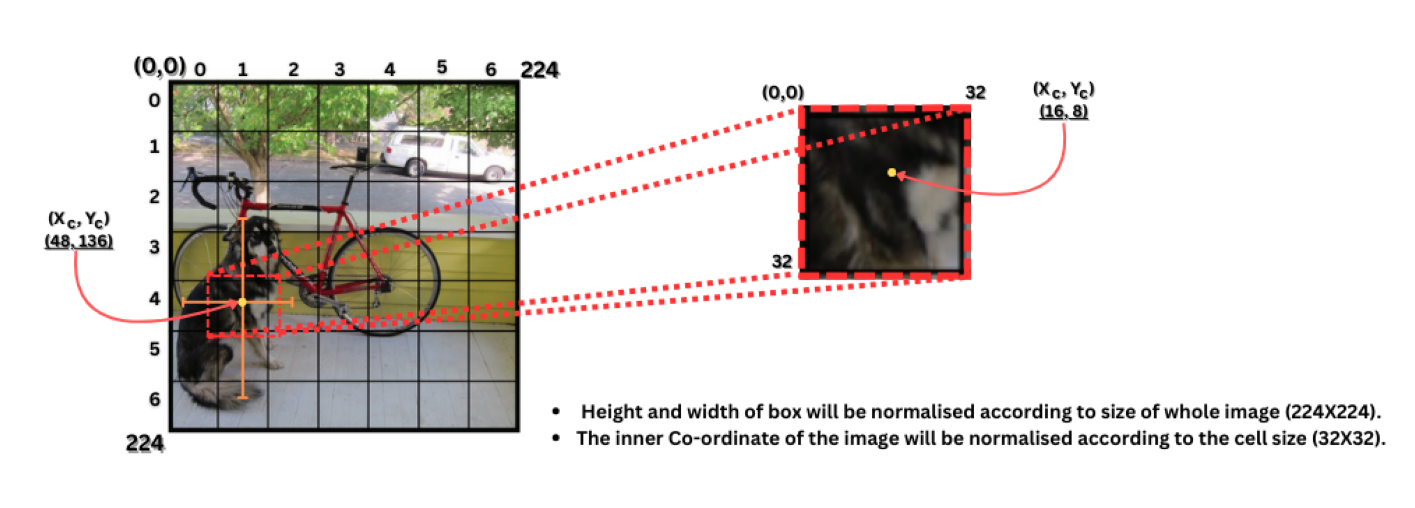

In [11]:
## Explaning  Downscaling and normalization
image = img.imread("/kaggle/input/yolo-concepts-explanation/Down Scaling and Normalization.png")
plt.figure(figsize=(18, 50))
plt.axis('off')
plt.imshow(image);

In [12]:
########### This function will convert the center cordination of center according to center cells. 
def generate_output(bounding_boxes):
  #### Creating numpy zeros array of the dimensions.
  output_label=np.zeros((SPLIT_SIZE,SPLIT_SIZE,N_CLASSES+5))
    
  for b in range(len(bounding_boxes)): ## iterating trough the length of bounding box i.e 5.

    #### Because we have already normalised bounding boxes via a function (cell 7).
    #### Now we will just mutiply cordinates by SPLIT_SIZE(=7) and then just save decimal part which is normailised co ordiante in the center cell  

    ######## Multiplying cordinate with split size 
    grid_x=bounding_boxes[...,b,0]*SPLIT_SIZE 
    grid_y=bounding_boxes[...,b,1]*SPLIT_SIZE

    ####### These are the cell's numbers(in i,j ) in the tensor,
    i=int(grid_x) 
    j=int(grid_y)
                   ##objects exist  ## putting decimal values   ## getting heights and weights from given bounding box
#                           |          |       |                     |                      |
#                           V          V       V                     V                      V
    output_label[i,j,0:5]=[1.,   grid_x%1,grid_y%1,   bounding_boxes[...,b,2], bounding_boxes[...,b,3]]

    ####### it will put put 1 on the index of array of which object exist in the cell
    output_label[i,j,5+int(bounding_boxes[...,b,4])]=1.

  ########## cconverting array into tensor and returning the tensor for training and validation
  return tf.convert_to_tensor(output_label,tf.float32)

In [13]:
## taking an example how a tensor containg object center will be
generate_output(preprocess_xml(train_maps + "2007_000032.xml"))[0][2]

<tf.Tensor: shape=(25,), dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>

In [14]:
# training list containg images excluding validations

a = set(os.listdir(train_images))
b = set(val_list)

train_list = list(a-b)
print("number of training images: ", len(train_list))

print("example of training images: ", train_list[0:5])


# training list containg maps excluding validations

a = set(os.listdir(train_maps))
b = set(val_list_maps)

train_list_maps = list(a-b)
print("number of training images: ", len(train_list_maps))

print("example of training images: ",train_list_maps[0:5])


number of training images:  17061
example of training images:  ['2011_002967.jpg', '2012_003631.jpg', '2008_000834.jpg', '2008_003104.jpg', '2008_004559.jpg']
number of training images:  17061
example of training images:  ['2010_006296.xml', '2008_002124.xml', '2012_000969.xml', '2008_006164.xml', '2010_005159.xml']


In [15]:
#### creating list of training & validation images and their annotations full paths

im_paths = [ '/kaggle/input/pascal-voc-2012/VOC2012/JPEGImages/' + i  for i in train_list ]

xml_paths = [ '/kaggle/input/pascal-voc-2012/VOC2012/Annotations/' + i  for i in train_list_maps ]

val_im_paths = [ '/kaggle/working/VOC2012/ValJPEGImages/' + i  for i in val_list ]

val_xml_paths = [ '/kaggle/working/VOC2012/ValAnnotations/' + i  for i in val_list_maps ]

In [16]:
print("No. of Validation images: ", len(val_im_paths)," , " ,"No. of Training images", len(im_paths))

print("No. of Validation annotation: ", len(val_xml_paths)," , " ,"No. of Training annotation", len(xml_paths))

No. of Validation images:  64  ,  No. of Training images 17061
No. of Validation annotation:  64  ,  No. of Training annotation 17061


In [17]:
## sorting the list of paths , so that the image and its annotation is same in their respective list

im_paths.sort()
xml_paths.sort()
val_im_paths.sort()
val_xml_paths.sort()

In [18]:
train_dataset=tf.data.Dataset.from_tensor_slices((im_paths,xml_paths))
val_dataset=tf.data.Dataset.from_tensor_slices((val_im_paths,val_xml_paths))

In [19]:
for i in train_dataset.take(1):
    print(i)

(<tf.Tensor: shape=(), dtype=string, numpy=b'/kaggle/input/pascal-voc-2012/VOC2012/JPEGImages/2007_000830.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/kaggle/input/pascal-voc-2012/VOC2012/Annotations/2007_000830.xml'>)


In [20]:
## Function to return image and bounding boxes into Tensors/ Vectors
def get_imbboxes(im_path, xml_paths):
    img = tf.io.decode_jpeg(tf.io.read_file(im_path))                        ## Images into Tensors
    img = tf.cast(tf.image.resize(img, size=[H, W]), dtype = tf.float32)     ## Resizing image

#                              using function and giving input to array of bounding boxes of an imagw
#                                       |                   |
#                                       V                   V
    bboxes = tf.numpy_function(func=preprocess_xml, inp=[xml_paths], Tout=tf.float32)   ## Making array of bounding box
    return (img,bboxes)

In [21]:
# Creating  new datasets where images and bounding box are tensors by mapping

train_dataset = train_dataset.map(get_imbboxes)
val_dataset = val_dataset.map(get_imbboxes)

In [22]:
print("For Training Dataset: ")
for i,j in train_dataset.skip(2):
  print("Dimensions of image: ", i.shape,", Dimensions of bounding box", j.shape)
  break
    
print("--------------------------------------------")

print("For Validation Dataset: ")
for i,j in val_dataset.skip(2):
  print("Dimensions of image: ", i.shape, ", Dimensions of bounding box", j.shape)
  break

For Training Dataset: 
Dimensions of image:  (244, 244, 3) , Dimensions of bounding box (1, 5)
--------------------------------------------
For Validation Dataset: 
Dimensions of image:  (244, 244, 3) , Dimensions of bounding box (3, 5)


# Data Augmentation

* It will create more images for training and also gaiving different angles, size and direction to view an imagee to our model

In [23]:
########## Making Data Augmentation Pipeline Using Albumentations library
########## For Training Datset

transforms = A.Compose([
    A.Resize(H,W),    ### Reszining image
    A.RandomCrop(     ## Radomaly croping image
         width=np.random.randint(int(0.9*W),W),    ## width
         height=np.random.randint(int(0.9*H),H), p=0.5),   ##height , ##p-> probablity of croping an image
    
    A.RandomScale(scale_limit=0.1, interpolation=cv2.INTER_LANCZOS4,p=0.5), # randomly sclaing image
    A.HorizontalFlip(p=0.5,), ## Horizontally flipping an image
    A.Resize(H,W)

], bbox_params=A.BboxParams(format='yolo', ))   ### transforming our bounding box  according to the the data augmentation is performed

In [24]:
## Function to do Data Augmentation on images and bboxes and convert tem into Tensors 
def aug_albument(image,bboxes):
  augmented=transforms(image=image,bboxes=bboxes)
  return [tf.convert_to_tensor(augmented["image"],dtype=tf.float32),   ## returning list of Tensors(image, bboxes)
          tf.convert_to_tensor(augmented["bboxes"],dtype=tf.float32)]

In [25]:
## Function that will give tuple of arrays of augmented images and bboxes
def process_data(image,bboxes):
    aug= tf.numpy_function(func=aug_albument, inp=[image,bboxes], Tout=(tf.float32,tf.float32))
    return aug[0],aug[1]

In [26]:
#### Creating new datasets having augmented data also

train_dataset=train_dataset.map(process_data)
val_dataset=val_dataset.map(process_data)

In [27]:
## Taking an example of data in validation dataset
for i,j in val_dataset.skip(2):
  print(i.shape,j)
  break

(244, 244, 3) tf.Tensor(
[[0.508      0.5054645  0.98       0.42622948 0.        ]
 [0.903      0.58196723 0.12199998 0.07103825 0.        ]
 [0.736      0.5614754  0.17200005 0.09562838 0.        ]], shape=(3, 5), dtype=float32)


In [28]:
train_dataset

<_MapDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=<unknown>, dtype=tf.float32, name=None))>

In [29]:
val_dataset

<_MapDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=<unknown>, dtype=tf.float32, name=None))>

In [30]:
## Taking an example of data in training dataset

print("Training dataset: ")
for i,j in train_dataset.take(1):
  print("Image dimension: ",i.shape, ", Bounding box dimension: ",j.shape)
  break
    
print("--------------------------------")

print("Validation dataset: ")
for i,j in val_dataset.take(1):
  print("Image dimension: ",i.shape, ", Bounding box dimension: ",j.shape)
  break

Training dataset: 
Image dimension:  (244, 244, 3) , Bounding box dimension:  (4, 5)
--------------------------------
Validation dataset: 
Image dimension:  (244, 244, 3) , Bounding box dimension:  (1, 5)


In [31]:
#### Data Augmentation using Tensorflow For Validation Dataset
def preprocess_augment(img,y):
  img = tf.image.random_brightness(img, max_delta=50.)   ## Changing image brightness #maxdelta->controls the maximum relative change in brightness.

#    lower ->Lower bound for the random saturation factor,
#    upper -> Upper bound for the random saturation factor.
  img = tf.image.random_saturation(img, lower=0.5, upper=1.5) ## Adjust the saturation of RGB images by a random factor.
  img = tf.image.random_contrast(img, lower=0.5, upper=1.5)   ## Adjust the contrast of images by a random factor deterministically.


  #img = tf.image.random_hue(img, max_delta=0.5 )    ##Adjust the hue of RGB images by a random factor.
  img = tf.clip_by_value(img, 0, 255)  ##Creaiting Image tensor between 0-255 ( Function Clips tensor values to a specified min and max)
    
  labels=tf.numpy_function(func=generate_output, inp=[y], Tout=(tf.float32)) ## Creating tensors of labels by using numpy function and mappinng our bounding box over generate_output function
  return img,labels  ## returning tuple of tensor image and tensor label of each cell in an image
#               ↑
#             (7X7X25) dimension

In [32]:
def preprocess(img,y):
  #img = tf.cast(tf.image.resize(img, size=[H, W]), dtype=tf.float32)
  img = tf.cast(img, dtype=tf.float32)  ## casting our image tensor in foat32
  labels=tf.numpy_function(func=generate_output, inp=[y], Tout=(tf.float32)) ##creating tensor of labels 
  return img,labels

In [33]:
## Creating Datasets with tensors of bboxes, class    
train_dataset = train_dataset.map(preprocess_augment)

val_dataset = val_dataset.map(preprocess)

In [34]:
train_dataset

<_MapDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=<unknown>, dtype=tf.float32, name=None))>

In [35]:
for i,j in train_dataset.take(1):
  print(i.shape,j.shape)
  break

(244, 244, 3) (7, 7, 25)


In [36]:
train_dataset

<_MapDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=<unknown>, dtype=tf.float32, name=None))>

In [37]:
val_dataset

<_MapDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=<unknown>, dtype=tf.float32, name=None))>

In [38]:
def ensure_shape(image, label):
    """
    Ensures the shape of the image and label tensors is defined.
    """
    image.set_shape([H, W, 3]) # or your expected input shape
    label.set_shape([7,7,25]) # or your expected label shape
    return image, label


# Creating datsets that ensures images and label Tensor's dimensions and shaape
train_dataset = train_dataset.map(ensure_shape)
val_dataset = val_dataset.map(ensure_shape)

In [39]:
# Creating final datasets

train_dataset=(
    train_dataset.
    batch(BATCH_SIZE).   #Grouping the train_dataset data into batches of a 32 size
    prefetch(tf.data.AUTOTUNE)    #It will overlap data during preprocessing and model execution.
)

val_dataset=(
    val_dataset.
    batch(BATCH_SIZE).
    prefetch(tf.data.AUTOTUNE)
)

In [40]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 244, 244, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7, 7, 25), dtype=tf.float32, name=None))>

In [41]:
val_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 244, 244, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7, 7, 25), dtype=tf.float32, name=None))>

# Model

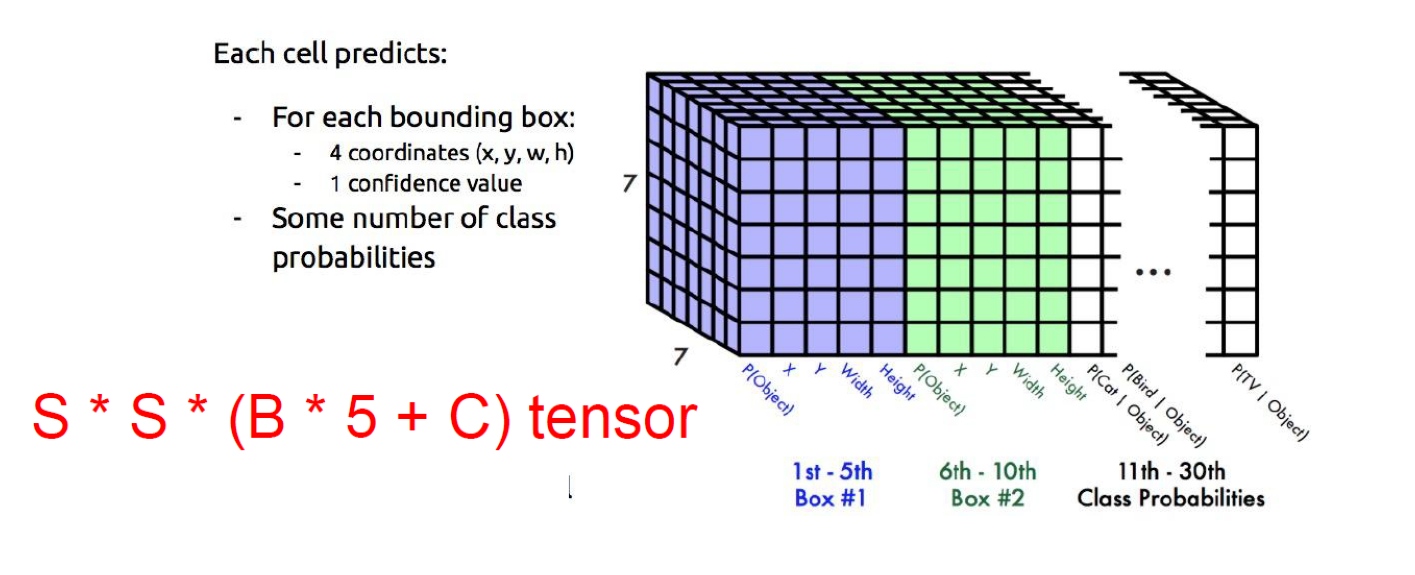

In [42]:
## Output/Prediction Tensor
image = img.imread("/kaggle/input/yolo-concepts-explanation/Prediction Tensor.png")
plt.figure(figsize=(18, 18))
plt.axis('off')
plt.imshow(image);

In [43]:
NUM_FILTERS = 512
OUTPUT_DIM = N_CLASSES + 5*B

* **Since we dont have enigh resources to train a image classification model for 1 week. Hence we will use a pretrained mdoel**

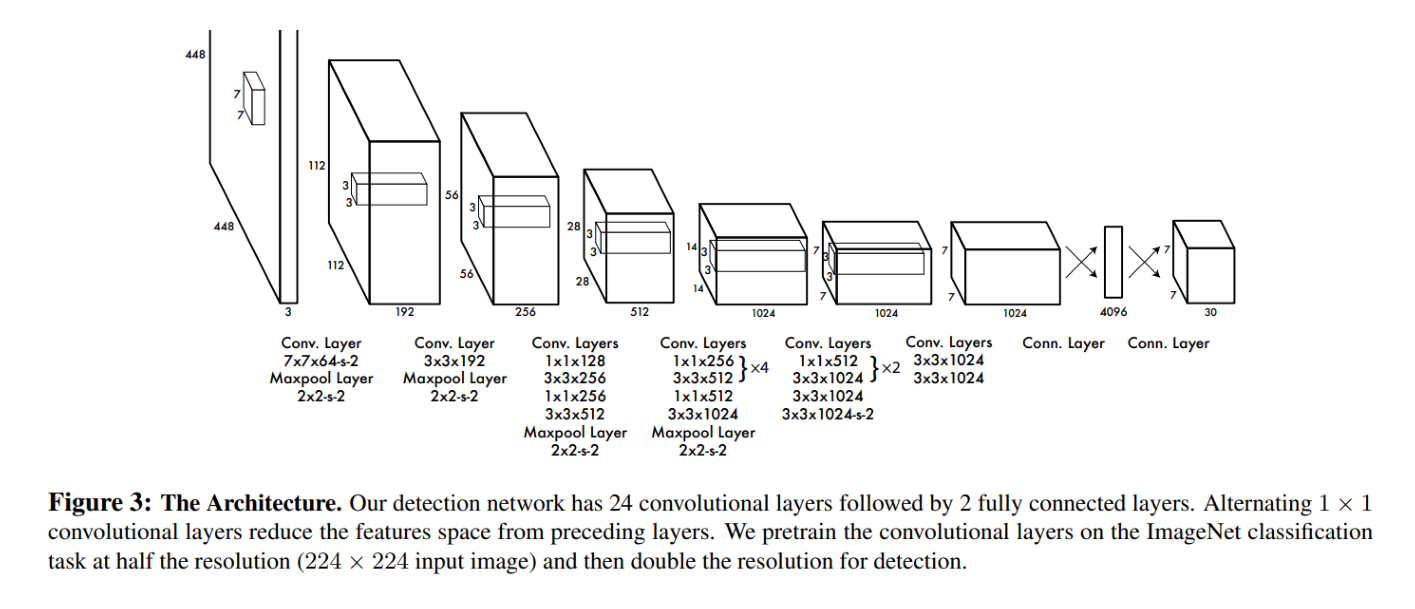

In [44]:
## Model Network 
image = img.imread("/kaggle/input/yolo-concepts-explanation/Model network.png")
plt.figure(figsize=(18, 18))
plt.axis('off')
plt.imshow(image);

In [45]:
base_model = tf.keras.applications.efficientnet.EfficientNetB1(
    weights = 'imagenet',
    input_shape = (H,W,3),
    include_top = False,
)

base_model.trainable = False

27018416/27018416 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### Creating the Sequentail model according to the yolo paper


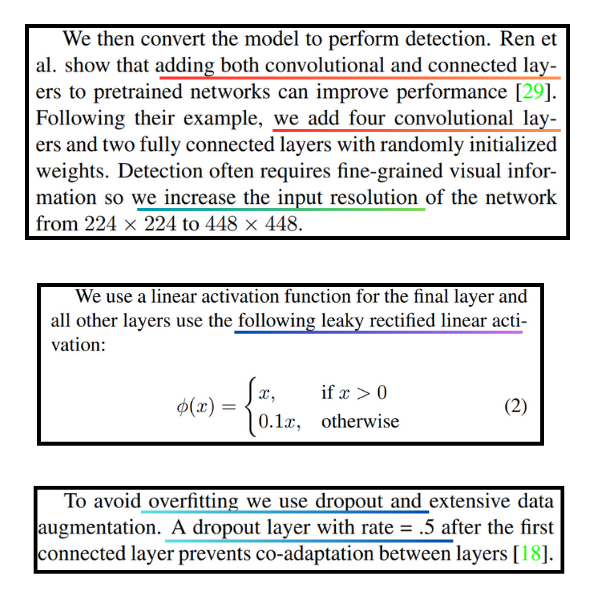
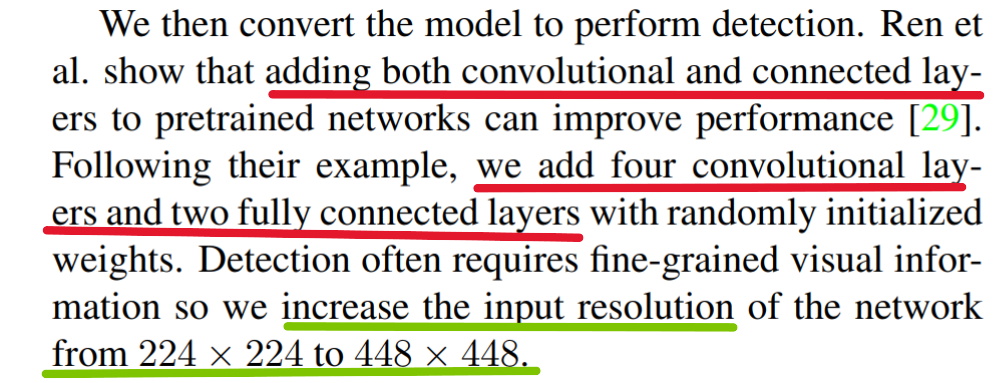
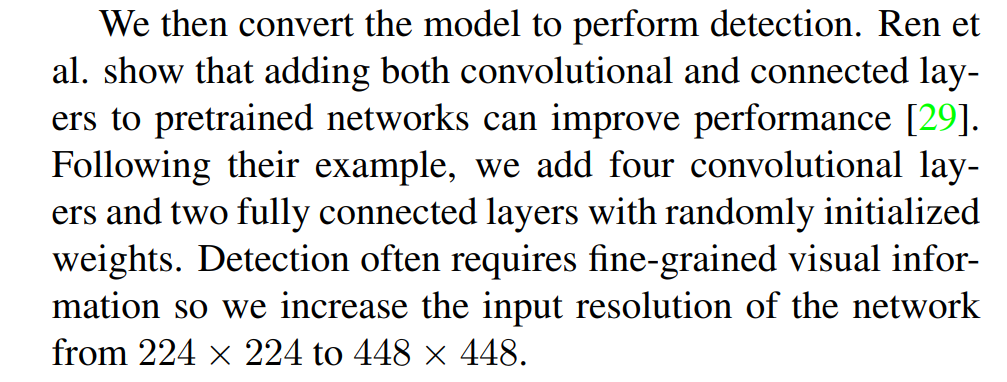
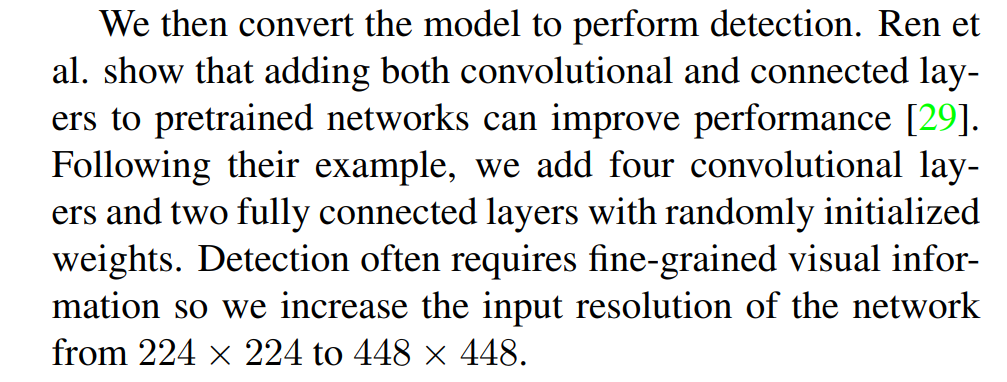

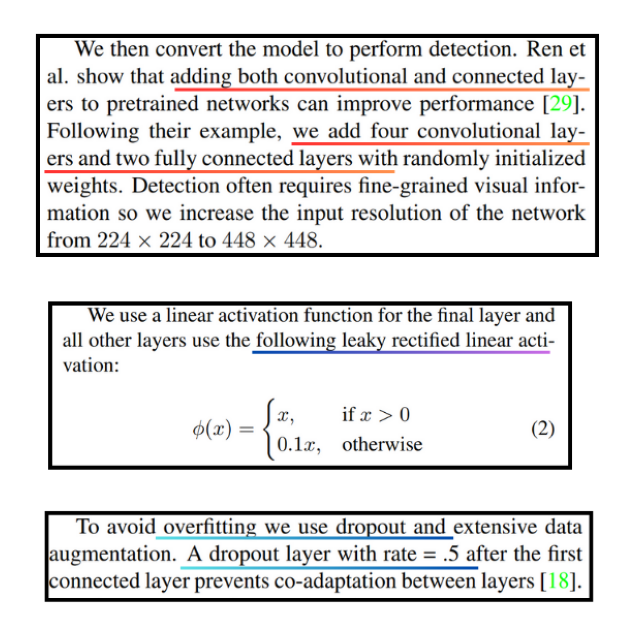

In [46]:
## Model Architecture
image = img.imread("/kaggle/input/yolo-concepts-explanation/Model Architecture.png")
plt.figure(figsize=(8, 10))
plt.axis('off')
plt.imshow(image);

In [47]:
model=tf.keras.Sequential([
  base_model, ### pretrained Model Base

  # 1st conv layer
  Conv2D(NUM_FILTERS,(3,3), padding = 'same',kernel_initializer='he_normal',),
  BatchNormalization(),
  LeakyReLU(alpha=0.1),

  # 2nd conv layer
  Conv2D(NUM_FILTERS,(3,3),padding = 'same',kernel_initializer='he_normal',),
  BatchNormalization(),
  LeakyReLU(alpha=0.1),

  # 3rd conv layer
  Conv2D(NUM_FILTERS,(3,3),padding = 'same',kernel_initializer='he_normal',),
  BatchNormalization(),
  LeakyReLU(alpha=0.1),

  # 4th conv layer
  Conv2D(NUM_FILTERS,(3,3),padding = 'same',kernel_initializer='he_normal',),
  LeakyReLU(alpha=0.1),

  Flatten(), 

  Dense(NUM_FILTERS,kernel_initializer='he_normal',),
  BatchNormalization(),
  LeakyReLU(alpha=0.1),

  Dropout(0.5),

  Dense(SPLIT_SIZE*SPLIT_SIZE*OUTPUT_DIM,  activation='sigmoid'), # linear activation function),

  Reshape((SPLIT_SIZE,SPLIT_SIZE,OUTPUT_DIM)), ### Altering Data Dimensions
])
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb1 (Functional)     │ ?                      │     6,575,239 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,575,239 (25.08 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 6,575,239 (25.08 MB)

## Loss Function

### IOU

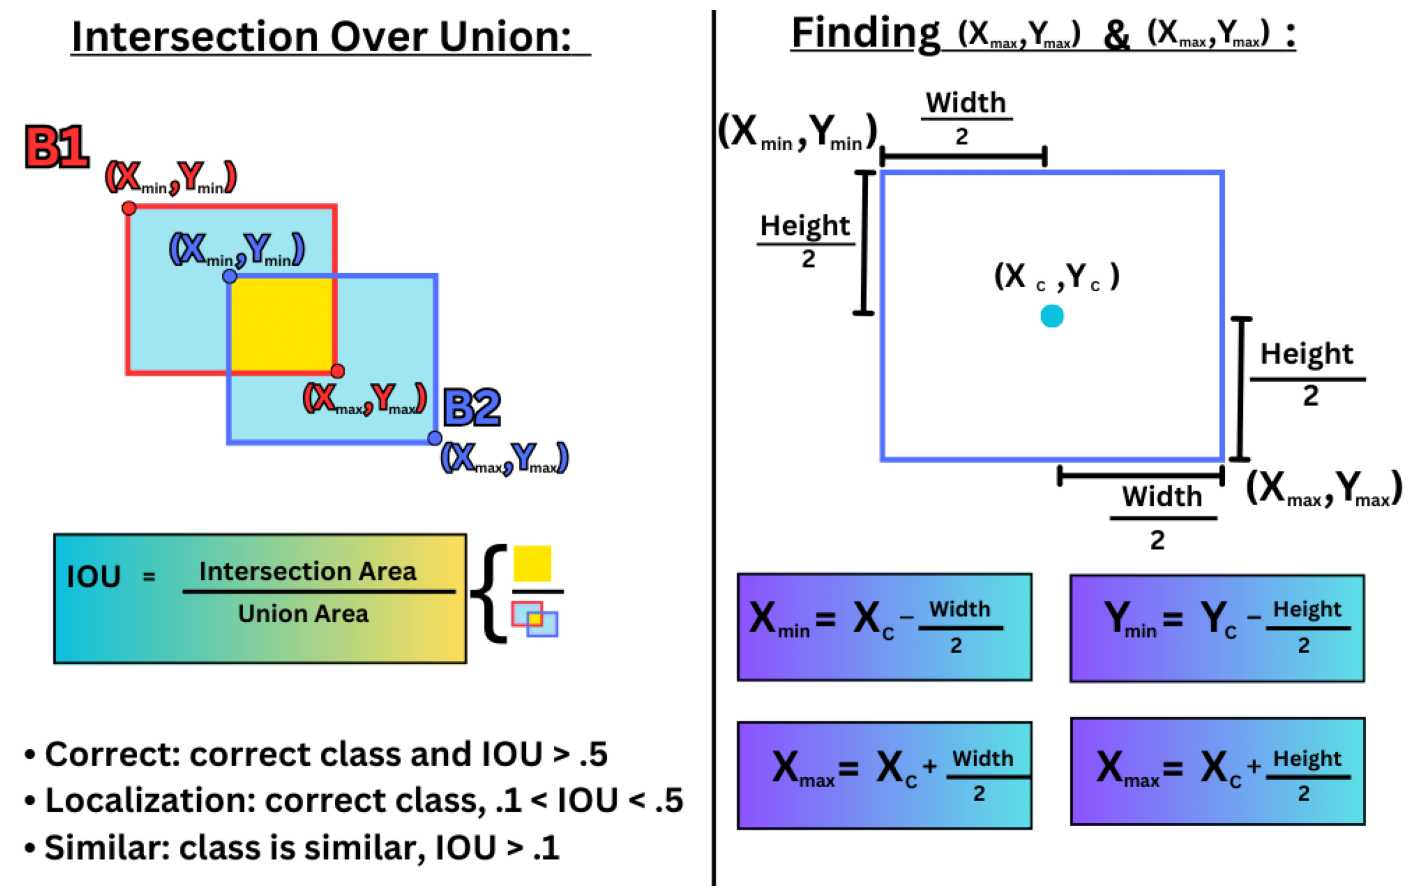

In [48]:
## IOU , Xmin, Xmax, Ymin and Ymax
image = img.imread("/kaggle/input/yolo-concepts-explanation/IOU , Xmin, Xmax, Ymin and Ymax.png")
plt.figure(figsize=(18, 18))
plt.axis('off')
plt.imshow(image);

In [49]:
##### function to calculate iou of two bounding boxes

######  boxes1[..., 0] = B1_X_Center ,   boxes1[..., 2] = B1_Y_Center,
######  boxes1[..., 0] = B1_Width ,   boxes1[..., 2] = B1_Height,

##### Since in dataset tensor x_center,y_center, height, width are there so first we will modify these and then find area and then IOU


##### We will use thius function to find IOU between original and predicted bounding box
def compute_iou(boxes1, boxes2):
    ###### creating tensors, that have box's x_min, y_min, x_max, y_max    

    boxes1_t = tf.stack([boxes1[..., 0] - boxes1[..., 2] / 2.0,    ### creating x_min
                         boxes1[..., 1] - boxes1[..., 3] / 2.0,    ### creating y_min
                         boxes1[..., 0] + boxes1[..., 2] / 2.0,    ### creating x_max
                         boxes1[..., 1] + boxes1[..., 3] / 2.0],   ### creating y_max
                        axis=-1)

    boxes2_t = tf.stack([boxes2[..., 0] - boxes2[..., 2] / 2.0,    ### creating x_min
                         boxes2[..., 1] - boxes2[..., 3] / 2.0,    ### creating y_min
                         boxes2[..., 0] + boxes2[..., 2] / 2.0,    ### creating x_max
                         boxes2[..., 1] + boxes2[..., 3] / 2.0],   ### creating y_max
                        axis=-1)

    lu = tf.maximum(boxes1_t[..., :2], boxes2_t[..., :2]) ### returning maximum co-ordinate of (x_min, y_min) between the boxes1, boxes2, Which is (X_min, y_min) of intersected box.
    rd = tf.minimum(boxes1_t[..., 2:], boxes2_t[..., 2:]) ### returning maximum co-ordinate of (x_max, y_max) between the boxes1, boxes2, Which is (X_min, y_min) of intersected box.

    intersection = tf.maximum(0.0, rd - lu) # returning tensor rd-lu i.e. (height, width) { because width =x_max-x_min; height =y_max- y_min}
#                               ↑ 
#     in case there is no bounding box, the, a negative tensor will come which is samller than 0.0  and 0 will come over that here.
    
    inter_square = intersection[..., 0] * intersection[..., 1]  ### intersection_area = width*height

    square1 = boxes1[..., 2] * boxes1[..., 3]  ## width*height
    square2 = boxes2[..., 2] * boxes2[..., 3]  ## width*height

    ### Union Area
    union_square = tf.maximum(square1 + square2 - inter_square, 1e-10)
#                                                       ↑
#                               a very small non zero value that insures that area does not become negative                                      
    
    return tf.clip_by_value(inter_square / union_square, 0.0, 1.0) # retrining IOU
#                    ↑                                      ↑    ↑
#   It will change IOU to 0 if it is lesser than 0 and convert it into 1 if it is greater than 1 

### Yolo Loss

In [50]:
def difference(x,y):
    """
    It wil first do element wise substraction between two tensors.
    Then it will saquare all of t.
    Then it wil sum all the elements in the tensor
    """
    return tf.reduce_sum(tf.square(y-x))
#                 ↑
# This sums up all the elements of the squared difference tensor.

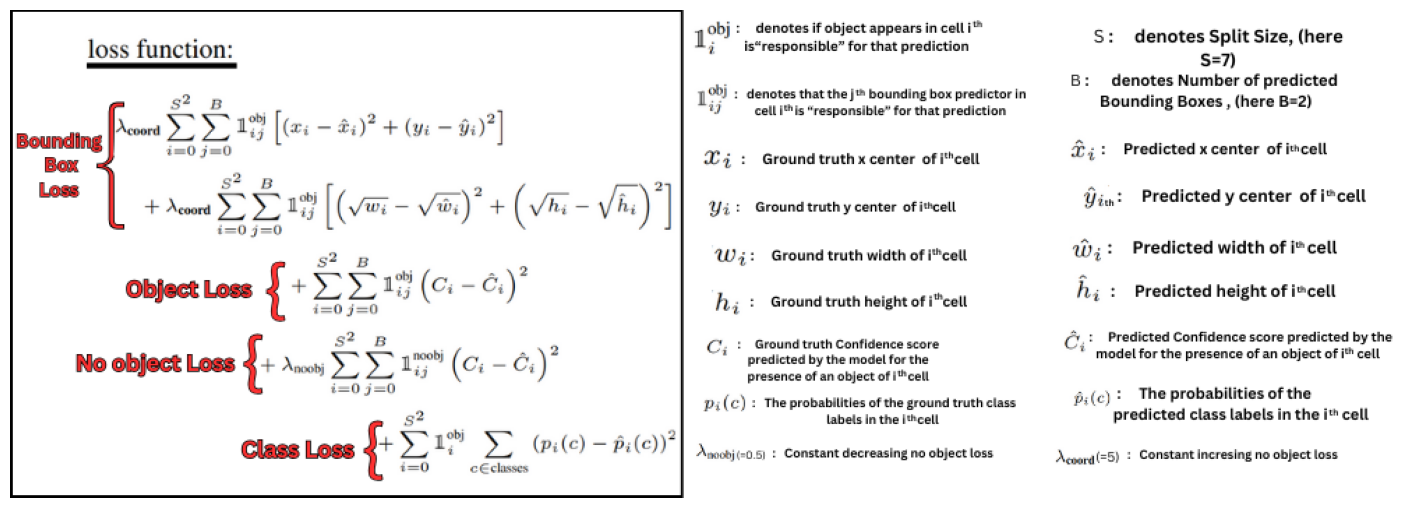

In [51]:
## YOLO Loss
image = img.imread("/kaggle/input/yolo-concepts-explanation/Loss Function.png")
plt.figure(figsize=(18, 18))
plt.axis('off')
plt.imshow(image);

In [52]:
def yolo_loss(y_true, y_pred):
    target = y_true[...,0]   ## extracting the first channel of the ground truth tensor (y_true), 
                             ## which represents the objectness mask (i.e., whether an object exists in a particular grid cell).



    
    ###################### Object Loss

#                                 finds the indices of all grid cells where an object is present
#                                                      🢃
    y_pred_extract = tf.gather_nd(y_pred, tf.where(target[:]==1))
    y_target_extract = tf.gather_nd(y_true, tf.where(target[:]==1))
 
    rescaler = tf.where(target[:]==1)*SPLIT_SIZE    ## Creating tensor with the value SPLIT_SIZE at the positions where an object is present and 0 otherwise, and rescaling data by multiplying by SPLIT_SIZE.
                      ##To remove the first column.
#                                       🢃   
    upscaler_1 = tf.concat([rescaler[:,1:], tf.zeros([len(rescaler),2], dtype=tf.int64)],axis=-1)   ## Constructing a tensor to be used for upscaling the coordinates of the bounding boxes.
#                     🢁
             ## Concatinating tensors

    ## These lines will upscale the coordinates of the ground truth and predicted bounding boxes to the Original image dimensions.
    
    ## Target Image Bounding Box 
#          🢃
    target_upscaler_2 = tf.repeat([[float(SPLIT_SIZE),float(SPLIT_SIZE),H,W]],     ### List containing the SPLIT_SIZE, SPLIT_SIZE, height, width of image
                         repeats=[len(rescaler)], axis=0) * tf.cast(y_target_extract[...,1:5], dtype = tf.float32)  ## multiplying the target co-ordinates and dimensions to upscale them.
#                           🢁
#    Repeats this list len(rescaler) times along the 0th axis (creating a new dimension).
#This effectively creates a tensor with len(rescaler) rows, where each row contains the same four values.


    pred_1_upscaler_2 = tf.repeat([[float(SPLIT_SIZE),float(SPLIT_SIZE),H,W]],     ### Predicted Image 1 Bounding Box
                        repeats=[len(rescaler)], axis=0)*tf.cast(y_pred_extract[...,1:5], dtype = tf.float32)
    
    pred_2_upscaler_2 = tf.repeat([[float(SPLIT_SIZE),float(SPLIT_SIZE),H,W]],     ### Predicted Image 2 Bounding Box
                        repeats=[len(rescaler)], axis=0)*tf.cast(y_pred_extract[...,6:10], dtype = tf.float32)

    ## These lines calculate the original coordinates of the ground truth and predicted bounding boxes by adding the upscaled coordinates to the upscaler_1 tensor.
    target_orig = tf.cast(upscaler_1, dtype = tf.float32)+target_upscaler_2
    pred_1_orig = tf.cast(upscaler_1, dtype = tf.float32)+pred_1_upscaler_2
    pred_2_orig = tf.cast(upscaler_1, dtype = tf.float32)+pred_2_upscaler_2

    ## It will determines which prediction (between two sets of predictions) has a higher IoU with the ground truth
    mask =tf.cast(tf.math.greater(compute_iou(target_orig,pred_2_orig),
                                          compute_iou(target_orig,pred_1_orig)),dtype=tf.int32)

    ##  Combining the objectness scores of the two sets of predictions.
    y_pred_joined=tf.transpose(tf.concat([tf.expand_dims(y_pred_extract[...,0],axis=0),
                         tf.expand_dims(y_pred_extract[...,5],axis=0)],axis=0))

    obj_pred = tf.gather_nd(y_pred_joined,tf.stack([tf.range(len(rescaler)),mask],axis=-1))

    ## Calculating the object loss, which penalizes the model for incorrect objectness predictions.
    object_loss = difference(tf.cast(obj_pred,dtype =tf.float32)
                             ,tf.cast(tf.ones([len(rescaler)]),dtype=tf.float32))





    
    ####################### For No object
#                                                    where the taget is 0
#                                                         🢃       
    y_pred_extract = tf.gather_nd(y_pred[...,0:B*5], tf.where(target[:]==0))
#                                      🢁
#                            selects a predicted coordinates and classes portion of the prediction tensor


    y_target_extract = tf.zeros(len(y_pred_extract)) #This creates a tensor of zeros with the same length as y_pred_extract.
                                                     #This will be used as the ground truth for the no-object loss calculation.
 
#                      This part of tensor shows that there is any object or not for first set of prediction      
# difference->square->addtion of elements of two tensors       ┃
#                          🢃                                  🢃
    no_object_loss_1 = difference(tf.cast(y_pred_extract[...,0],dtype =tf.float32)
                             ,tf.cast(y_target_extract,dtype=tf.float32))  ## whether there is actually an object or not

#                      This part of tensor shows that there is any object or not for second set of prediction 
# difference->square->addtion of elements of two tensors       ┃
#                          🢃                                  🢃
    no_object_loss_2 = difference(tf.cast(y_pred_extract[...,5],dtype =tf.float32)
                             ,tf.cast(y_target_extract,dtype=tf.float32))  ## whether there is actually an object or not

    no_object_loss = no_object_loss_1+no_object_loss_2  ## adding both losses of two predictions





    

    ######################## For OBject class loss
    y_pred_extract = tf.gather_nd(y_pred[...,10:],tf.where(target[:]==1))  ###Finding the indies of tensor where target==1.Then retrieves the predicted class probabilities  at the specified indices
    class_extract = tf.gather_nd(y_true[...,5:],tf.where(target[:]==1))    ### Extracting the ground truth class labels for the locations where the actual target indicates the presence of an object.

#    difference->square->addtion of elements of two tensors       
#                      🢃 
    class_loss = difference(tf.cast(y_pred_extract,dtype =tf.float32)
                                 ,tf.cast(class_extract,dtype=tf.float32))




    



    ######################### For object bounding box loss
    y_pred_extract = tf.gather_nd(y_pred[...,0:B*5], tf.where(target[:]==1)) ## getting tensor of two set of bounding box prediction co-ordinates and dimensions
#                                               B1                       B2
#                                               🢃                        🢃
    centre_joined=tf.stack([y_pred_extract[...,1:3],y_pred_extract[...,6:8]],axis=1) ## Stacking the predicted center coordinates (x, y) from two sets of predictions.
    centre_pred = tf.gather_nd(centre_joined,tf.stack([tf.range(len(rescaler)),mask],axis=-1)) ## Taking center coordinates (x, y) of Box with highest IOU
    centre_target = tf.gather_nd(y_true[...,1:3], tf.where(target[:]==1)) ## Real center coordinates (x, y)
    
#    difference->square->addtion of elements of two tensors       
#                      🢃 
    centre_loss = difference(centre_pred,centre_target) ## loss of center coordinates prediction

    
    size_joined=tf.stack([y_pred_extract[...,3:5],y_pred_extract[...,8:10]],axis=1) ## Stacking the predicted center coordinates (x, y) from two sets of predictions.

    size_pred = tf.gather_nd(size_joined,tf.stack([tf.range(len(rescaler)),mask],axis=-1)) ## Taking width, height of Box with highest IOU
    size_target = tf.gather_nd(y_true[...,3:5], tf.where(target[:]==1)) ## Real widh and height

#    difference->square->addtion of elements of two tensors       
#                      🢃 
    size_loss = difference(tf.math.sqrt(tf.math.abs(size_pred)),tf.math.sqrt(tf.math.abs(size_target)))
    box_loss = centre_loss+size_loss


    
    lambda_coord = 5.0    ## increasing the loss from bounding box coordinate predictions.
    lambda_no_obj = 0.5   ## decreasing the loss from confidence predictions for boxes that don’t contain objects.


    ##  Total Loss calculation
    loss = (object_loss   
            + (lambda_no_obj*no_object_loss)
            + tf.cast(lambda_coord*box_loss,dtype=tf.float32)
            + tf.cast(class_loss,dtype=tf.float32))

    return loss

In [53]:
## Making model directory
os.mkdir('/kaggle/working/model')

In [54]:
checkpoint_filepath = '/kaggle/working/model/yolo_ressnet_50.weights.h5'
model_filepath = '/kaggle/working/model/yolo_ressnet_50.h5'
model_json_filepath = '/kaggle/working/model/yolo_ressnet_50.json'

callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath,
    save_weights_only = True,
    monitor = 'val_loss',
    mode = 'min',
    save_best_only = True
)

## Learning Rate

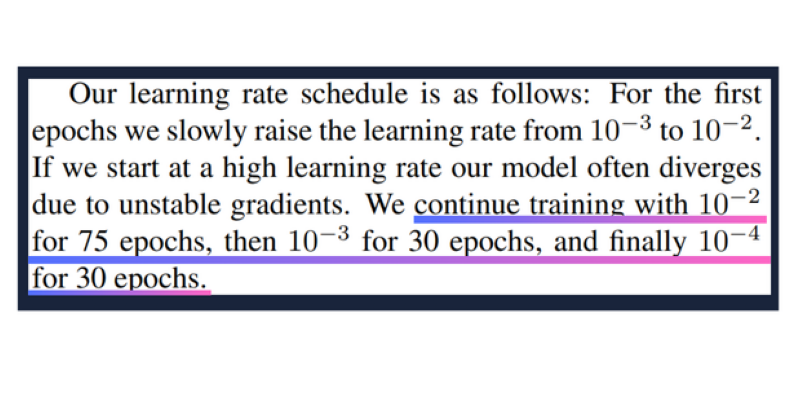

In [55]:
## Learning Rate
image = img.imread("/kaggle/input/yolo-concepts-explanation/Learning rate.png")
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(image);

In [56]:
#### we are changing our learning rate scheduler a little bit
def scheduler(epoch, lr):
    if epoch<40:
        return 1e-3
    elif epoch>=40 and epoch<80:
        return 5e-4
    else:
        return 1e-4

In [57]:
lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [58]:
model.compile(
    loss=yolo_loss,
    optimizer=Adam(1e-3),
    run_eagerly=True,
)

## Training

In [59]:
history = model.fit(
    train_dataset,
    validation_data = val_dataset,
    verbose = 1,
    epochs = N_EPOCHS,
    callbacks = [lr_callback, callback]
)

Epoch 1/60
  3/534 ━━━━━━━━━━━━━━━━━━━━ 10:30 1s/step - loss: 1028.0295

/opt/conda/lib/python3.10/site-packages/albumentations/core/bbox_utils.py:476: RuntimeWarning: invalid value encountered in divide
  & (clipped_box_areas / denormalized_box_areas >= min_visibility - epsilon)


534/534 ━━━━━━━━━━━━━━━━━━━━ 647s 1s/step - loss: 280.2637 - val_loss: 234.9558 - learning_rate: 0.0010
Epoch 2/60
534/534 ━━━━━━━━━━━━━━━━━━━━ 639s 1s/step - loss: 189.8563 - val_loss: 225.4671 - learning_rate: 0.0010
Epoch 3/60
534/534 ━━━━━━━━━━━━━━━━━━━━ 632s 1s/step - loss: 178.3148 - val_loss: 195.2961 - learning_rate: 0.0010
Epoch 4/60
534/534 ━━━━━━━━━━━━━━━━━━━━ 630s 1s/step - loss: 169.1510 - val_loss: 199.7649 - learning_rate: 0.0010
Epoch 5/60
534/534 ━━━━━━━━━━━━━━━━━━━━ 629s 1s/step - loss: 162.0340 - val_loss: 201.1625 - learning_rate: 0.0010
Epoch 6/60
534/534 ━━━━━━━━━━━━━━━━━━━━ 634s 1s/step - loss: 155.7372 - val_loss: 182.2062 - learning_rate: 0.0010
Epoch 7/60
534/534 ━━━━━━━━━━━━━━━━━━━━ 673s 1s/step - loss: 150.7802 - val_loss: 175.8396 - learning_rate: 0.0010
Epoch 8/60
534/534 ━━━━━━━━━━━━━━━━━━━━ 677s 1s/step - loss: 146.7878 - val_loss: 168.8186 - learning_rate: 0.0010
Epoch 9/60
534/534 ━━━━━━━━━━━━━━━━━━━━ 637s 1s/step - loss: 143.0362 - val_loss: 169.9791 

# Testing

## saving Model, Model's weights and json file

In [60]:
model.load_weights(checkpoint_filepath)


model_json = model.to_json()
with open(model_json_filepath, "w") as json_file:
    json_file.write(model_json)


model.save(model_filepath)

In [61]:
os.mkdir("outputs")

COCO_PATH = "/kaggle/input/coco-2017-dataset/coco2017/test2017/"

In [62]:
def model_test(filename):
  try:
    test_path=COCO_PATH+filename

    # print(test_path)

    img=cv2.resize(cv2.imread(test_path),(H,W))

    image=tf.io.decode_jpeg(tf.io.read_file(test_path))
    image=tf.image.resize(image, [H,W])
    output=model.predict(np.expand_dims(image, axis = 0))

    THRESH=.25

    object_positions=tf.concat(
                        [tf.where(output[...,0]>=THRESH),tf.where(output[...,5]>=THRESH)],axis=0)   ## getting output position, when P(object) >=0.25
    # print(object_positions)
    selected_output=tf.gather_nd(output,object_positions)
    # print(selected_output)
    final_boxes=[]
    final_scores=[]

    for i,pos in enumerate(object_positions):
      for j in range(2):
        if selected_output[i][j*5]>THRESH:
          output_box=tf.cast(output[pos[0]][pos[1]][pos[2]][(j*5)+1:(j*5)+5],dtype=tf.float32)

          x_centre=(tf.cast(pos[1],dtype=tf.float32)+output_box[0])*32
          y_centre=(tf.cast(pos[2],dtype=tf.float32)+output_box[1])*32

          x_width,y_height=tf.math.abs(H*output_box[2]),tf.math.abs(W*output_box[3])

          x_min,y_min=int(x_centre-(x_width/2)),int(y_centre-(y_height/2))
          x_max,y_max=int(x_centre+(x_width/2)),int(y_centre+(y_height/2))

          if(x_min<=0):x_min=0
          if(y_min<=0):y_min=0
          if(x_max>=W):x_max=W
          if(y_max>=H):y_max=H
          final_boxes.append(
              [x_min,y_min,x_max,y_max,
              str(classes[tf.argmax(selected_output[...,10:],axis=-1)[i]])])
          final_scores.append(selected_output[i][j*5])
    # print(final_scores)
    # print('finalboxes',final_boxes)
    final_boxes=np.array(final_boxes)

    object_classes=final_boxes[...,4]
    nms_boxes=final_boxes[...,0:4]

    nms_output=tf.image.non_max_suppression(
        nms_boxes,final_scores,max_output_size=100,iou_threshold=0.2,
        score_threshold=float('-inf')
    )
    # print(nms_output)

    for i in nms_output:
      cv2.rectangle(
          img,
          (int(final_boxes[i][0]),int(final_boxes[i][1])),
          (int(final_boxes[i][2]),int(final_boxes[i][3])),(0,0,255),1)
      cv2.putText(
          img,
          final_boxes[i][-1],
          (int(final_boxes[i][0]),int(final_boxes[i][1])+15),
          cv2.FONT_HERSHEY_COMPLEX_SMALL,1,(2,225,155),1
          )

    cv2.imwrite('/kaggle/working/outputs/'+filename[:-4]+'_det'+'.jpg',cv2.resize(img,(384,384)))
  except:
      pass
    # print("NO object found !!!")

In [63]:
# Testing model on 200 images
images_list = os.listdir(COCO_PATH)[:200]
for filename in images_list:
    model_test(filename)
    

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 